In [11]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [12]:
def mlp(hidden_sizes, activation = nn.ReLU, output_activation = nn.Identity):
    # Builds a simple MLP next
    
    layers = []

    for i in range(len(hidden_sizes) - 1):
        activ = activation if i < len(hidden_sizes) - 2 else output_activation
        layers += [nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), activ()]

    return nn.Sequential(*layers)

In [73]:
class REINFORCETrainer:
    ''' 
    REINFORCE algorithm
    Assumes discrete action space
    '''

    def __init__(self, 
                 env, 
                 pi_net_sizes = [32]
                 ):

        self.env = env
        self.nS = env.observation_space.shape[0] # dim of observations space
        self.nA = env.action_space.n             # dim of action space
        
        # policy neural net
        self.pi_mlp = mlp([self.nS] + pi_net_sizes + [self.nA])
        
    
    
    def policy(self, obs):
        logits = self.pi_mlp(obs)
        return Categorical(logits=logits)
    
    def sample_action(self, obs):
        return self.policy(obs).sample().item()
    
    def compute_pi_loss(self, observations, actions, returns):
        """
        In:
            observations - (T,nS) tensor
            actions      - (T, 1) tensor
            values       - (T, 1) tensor
        Out:
            policy net scalar loss
        """
        logp = self.policy(observations).log_prob(actions)
        return -(logp * returns).mean() 
    
    
    
    def compute_returns(self, rewards):
        returns = torch.zeros(len(rewards))
        returns[-1] = rewards[-1]
        
        for i in reversed(range(len(rewards)-1)):
            returns[i] = rewards[i] + returns[i+1]
        
        return returns
    


    def generate_episode(self):
        # logging
        ep_obs = []
        ep_act = []
        ep_rew = [] 

        obs, info = self.env.reset()


        while True:
            # sample action
            action = self.sample_action(torch.as_tensor(obs))

            # transition to next state
            next_obs, reward, terminated, truncated, info = self.env.step(action)

            # logging
            ep_obs.append(obs)
            ep_act.append(action)
            ep_rew.append(reward)

            if terminated or truncated:
                break

            obs = next_obs
        
        self.env.close()

        return len(ep_obs), ep_obs, ep_act, ep_rew
        


    def generate_batch(self, batch_size):
        '''
        In:
            batch_size - total number of steps
        Out:
            batch_obs - (B, nS)
            batch_act, batch_returns - (B,)
            batch_tot_ep_rew, batch_ep_lens - lists of length num_episodes
        '''
        # logging
        batch_obs = []
        batch_act = []
        batch_returns = []
        batch_tot_ep_rew = []
        batch_ep_lens = []

        episode_rew = [] 

        obs, info = self.env.reset()
        

        while len(batch_returns) <= batch_size:
            # sample action
            action = self.sample_action(torch.as_tensor(obs))

            # transition to next state
            next_obs, reward, terminated, truncated, info = self.env.step(action)

            # logging
            batch_obs.append(obs)
            batch_act.append(action)
            episode_rew.append(reward)


            if not (terminated or truncated):
                obs = next_obs
            else:
                returns = self.compute_returns(episode_rew)
                episode_rew = []
                
                batch_returns += returns

                batch_tot_ep_rew.append(returns[0])
                batch_ep_lens.append(len(returns))

                obs, info = self.env.reset()

        
        self.env.close()
                
        
        batch_obs = torch.from_numpy(np.stack(batch_obs))
        batch_act = torch.tensor(batch_act)
        batch_returns = torch.tensor(batch_returns)


        return batch_obs, batch_act, batch_returns, batch_tot_ep_rew, batch_ep_lens



    def train_one_epoch(self, batch_logs, pi_optimizer):
        
        batch_obs, batch_act, batch_returns, batch_tot_ep_rew, batch_ep_lens = batch_logs

        pi_optimizer.zero_grad()
        pi_loss = self.compute_pi_loss(batch_obs, batch_act, batch_returns)
        pi_loss.backward()
        pi_optimizer.step()

        return pi_loss


    def train(self, n_epochs, batch_size = 5000, pi_lr = 1e-2):

        # logging
        total_rewards = []
        
        pi_optimizer = Adam(self.pi_mlp.parameters(), lr = pi_lr)

        for i in tqdm(range(n_epochs)):
            batch_logs = self.generate_batch(batch_size)
            pi_loss = self.train_one_epoch(batch_logs, pi_optimizer)
            
            # logging
            batch_obs, batch_act, batch_returns, batch_tot_ep_rew, batch_ep_lens = batch_logs

            ave_tot_rew = sum(batch_tot_ep_rew)/len(batch_tot_ep_rew)
            total_rewards.append(ave_tot_rew)
            
            print(f'Batch {i+1} average return: {ave_tot_rew:.0f}')
        
        # clear_output()

        return total_rewards
    





# Cart Pole

## One training stats

In [62]:
env = gym.make('CartPole-v1')
R = REINFORCETrainer(env)

In [63]:
total_rewards = R.train(n_epochs=200, batch_size=5000)

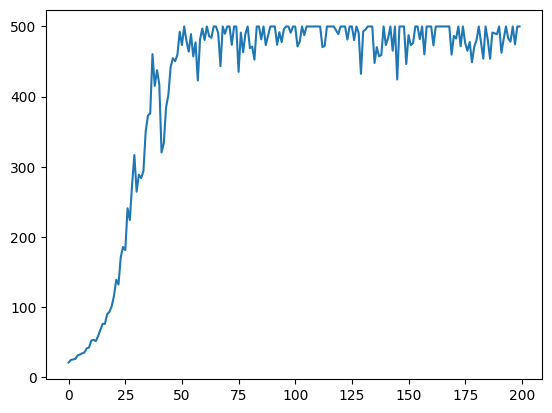

In [64]:
plt.plot(total_rewards)
plt.show()

The total rewards per episode saturates at 500, because the CartPole-v1 environment truncates at 500 steps.

In [66]:
rews = np.array(total_rewards)
# np.save('train_stats/1run_REINFORCE.npy', rews)
rews = np.load('train_stats/1run_REINFORCE.npy')

## Average over many training runs

In [ ]:
rews = []

for i in tqdm(range(30)):
    env = gym.make('CartPole-v1')
    R = REINFORCETrainer(env)
    curr_total_rewards = R.train(n_epochs=100, batch_size=5000)
    rews.append(curr_total_rewards)

In [75]:
rews = np.array(rews)

Load saved training stats

In [80]:
#np.save('train_stats/rews_30runs_REINFORCE.npy', rews)
rews = np.load('train_stats/rews_30runs_REINFORCE.npy')

Average training over 30 runs. Each run is 70 batches with 5000 steps per batch.

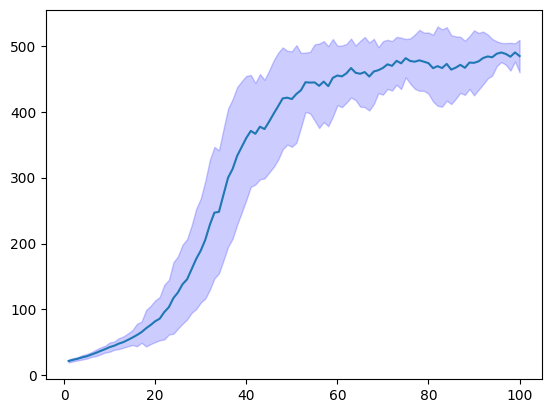

In [81]:
rews_mean = np.mean(rews, axis = 0)
rews_std = np.std(rews, axis = 0)

epochs = list(range(1,len(rews_mean)+1))
plt.plot(epochs, rews_mean)
plt.fill_between(epochs, rews_mean - rews_std, rews_mean + rews_std, color='blue', alpha=0.2)
plt.show()


# Lunar Lander

In [52]:
env = gym.make('LunarLander-v2')
R = REINFORCETrainer(env)

In [53]:
total_rewards = []

In [56]:
total_rewards += R.train(n_epochs=500, batch_size=5000, pi_lr = 1e-3)

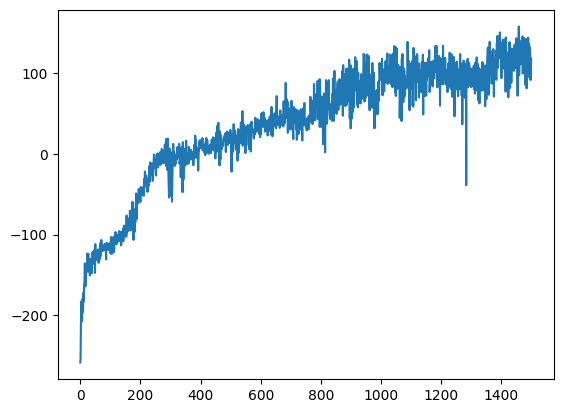

In [57]:
plt.plot(total_rewards)
plt.show()